In [1]:
import sys
import os
from xml.etree import ElementTree
from xml.etree.ElementTree import Element, SubElement
from lxml import etree
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import cv2


In [2]:
XML_EXT = '.xml'
ENCODE_METHOD = 'utf-8'

class PascalVocReader:

    def __init__(self, filepath):
        # shapes type:
        # [labbel, [(x1,y1), (x2,y2), (x3,y3), (x4,y4)], color, color, difficult]
        self.shapes = []
        self.filepath = filepath
        self.verified = False
        try:
            self.parseXML()
        except:
            print("could not open")
            pass

    def getShapes(self):
        return self.shapes
    
    def getNumShapes(self):
        return len(self.shapes)
    
    def getMinMaxXY(self, index):
        xmin = self.shapes[index][1][0][0]
        ymin = self.shapes[index][1][0][1]
        xmax = self.shapes[index][1][2][0]
        ymax = self.shapes[index][1][2][1] 
        return xmin, ymin, xmax, ymax

    def getShapeLabel(self, index):        
        return self.shapes[index][0] 
    
    def addShape(self, label, bndbox, difficult):
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        points = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
        self.shapes.append((label, points, None, None, difficult))

    def parseXML(self):
        assert self.filepath.endswith(XML_EXT), "Unsupport file format"
        parser = etree.XMLParser(encoding=ENCODE_METHOD)
        xmltree = ElementTree.parse(self.filepath, parser=parser).getroot()
        filename = xmltree.find('filename').text
        try:
            verified = xmltree.attrib['verified']
            if verified == 'yes':
                self.verified = True
        except KeyError:
            self.verified = False

        for object_iter in xmltree.findall('object'):
            bndbox = object_iter.find("bndbox")
            label = object_iter.find('name').text
            # Add chris
            difficult = False
            if object_iter.find('difficult') is not None:
                difficult = bool(int(object_iter.find('difficult').text))
            self.addShape(label, bndbox, difficult)
        return True



In [3]:
# filepath = "./Bbox_Junaid/test/grp_Beschädigung-4_num_23_id_162392448.xml"
# xmlReader = PascalVocReader(filepath=filepath)
# xmlReader.filepath
# xmlReader.getShapeLabel(1)

In [4]:
.# for i in range(0, xmlReader.getNumShapes()):
#     print(i)
#     print("Shapes Box [",i,"]", xmlReader.getMinMaxXY(i) )
# # print( xmlReader.getShapes())
# # print("=========")
# # for box in xmlReader.getShapes():
# #     print("label = ", box[0])
# #     print("xmin = ", box[1][0][0])
# #     print("ymin = ", box[1][0][1])
# #     print("xmax = ", box[1][2][0])
# #     print("ymax = ", box[1][2][1])    
    

In [5]:
batch_file = "./csv_data/batch/steinschlag/steinschlag_batch_5_of_8.csv"
batch_file = "./csv_data/batch/dellen/dellen_batch_7_of_8.csv"

In [6]:
df_batch = pd.read_csv(batch_file, sep="|")

In [7]:
df_batch.head()

uid  \
0  0027a209-cd60-44b4-96a5-37ae4fbf83f9   
1  0152e420-01ef-449d-88f1-23b27956810d   
2  025550c7-10e8-46a2-920f-bf79535bf322   
3  0577de6f-322f-4664-805a-13613e2c7c88   
4  06ebb461-8f9c-45b6-a286-11f79bab7473   

                                      bildname mbv color  damage  \
0   grp_Beschädigung-5_num_35_id_147987960.jpg  1T    Z2  dellen   
1  grp_Beschädigung-14_num_46_id_136078301.jpg  3G    P0  dellen   
2   grp_Beschädigung-4_num_33_id_153619213.jpg  1T    5K  dellen   
3   grp_Beschädigung-5_num_23_id_147821253.jpg  5G    2T  dellen   
4   grp_Beschädigung-2_num_17_id_131844738.jpg  8X    0E  dellen   

                        action                           part    cost  \
0          sanft instandsetzen         tür hinten links - tür  100.00   
1  instandsetzen und lackieren            fahrzeugdach - dach  827.03   
2          sanft instandsetzen  seitenwand links - seitenwand   80.00   
3          sanft instandsetzen            fahrzeugdach - dach  130.00   
4          sanft instandsetzen         tür hinten links - tür  100.00   

  damage_en         action_en                      part_en           part_p1  \
0      dent     gently repair      door behind left - door  tür hinten links   
1      dent  repair and paint           vehicle roof - top      fahrzeugdach   
2      dent     gently repair   Side wall left - Side wall  seitenwand links   
3      dent     gently repair           vehicle roof - top      fahrzeugdach   
4      dent     gently repair      door behind left - door  tür hinten links   

      part_p2                                      img_file_path  \
0         tür  ./data/img/0027a209-cd60-44b4-96a5-37ae4fbf83f...   
1        dach  ./data/img/0152e420-01ef-449d-88f1-23b27956810...   
2  seitenwand  ./data/img/025550c7-10e8-46a2-920f-bf79535bf32...   
3        dach  ./data/img/0577de6f-322f-4664-805a-13613e2c7c8...   
4         tür  ./data/img/06ebb461-8f9c-45b6-a286-11f79bab747...   

                                       ann_file_path  status  dirty  
0  ./data/annotation/0027a209-cd60-44b4-96a5-37ae...   False  False  
1  ./data/annotation/0152e420-01ef-449d-88f1-23b2...   False  False  
2  ./data/annotation/025550c7-10e8-46a2-920f-bf79...   False  False  
3  ./data/annotation/0577de6f-322f-4664-805a-1361...   False  False  
4  ./data/annotation/06ebb461-8f9c-45b6-a286-11f7...   False  False

In [8]:
def crop_image(imgName, imgOutName, xmin, ymin, xmax, ymax):
    img = cv2.imread(imgName)
    crop_img = img[ymin:ymax, xmin:xmax]
    #plt.imshow(img)
    #plt.show()
    plt.imshow(crop_img)
    plt.show()

In [9]:
filepath = "./Bbox_Junaid/test/grp_Beschädigung-4_num_23_id_162392448.xml"
xmlReader = PascalVocReader(filepath=filepath)

for i in range(0, xmlReader.getNumShapes()):
    xmin, ymin, xmax, ymax = xmlReader.getMinMaxXY(i) 
    test_img = "Bbox_Junaid/test/grp_Beschädigung-4_num_23_id_162392448.jpg"
    crop_image(test_img, test_img, xmin, ymin, xmax, ymax)

could not open


In [10]:
crop_table = []
crop_table_header = ['uid', 'bildname', 'damage', 'action', 'crop_img', 'label']
fs_home_path = "/home/mohsan/vwfs_p2/data/original/img"
base_dir = "./data/"
crop_folder = "cropped"
count = 0
def process_ann(row):
    global count
    row_list = row.tolist()
    uid = row['uid']
    bildname = row['bildname']
    status = row['status']
    dirty = row['dirty']
    damage = row['damage']
    action = row['action']
    crop_row = [uid, bildname, damage, action]    
    
    if status and not dirty:
        img_path_file = os.path.join(fs_home_path, uid, bildname )
        xml_path_file = os.path.join(base_dir, 'annotation', "{}.xml".format(bildname.split(".")[0]) )
        print(xml_path_file)        
        xmlReader = PascalVocReader(filepath=xml_path_file)
        for shape_index in range(0, xmlReader.getNumShapes()):
            img_crop = os.path.join(base_dir, crop_folder, "{}_Crop_{}.jpg".format(bildname.split(".")[0], shape_index) )
            #print(img_crop)
            merged_row = crop_row + [img_crop , xmlReader.getShapeLabel(shape_index)]
            #print(merged_row)
            xmin, ymin, xmax, ymax = xmlReader.getMinMaxXY(shape_index)
            crop_table.append(merged_row)
            if count < 100:
                print(xmlReader.getShapeLabel(shape_index))            
                crop_image(img_path_file, img_path_file,xmin, ymin, xmax, ymax )
        count += 1
    return True

./data/annotation/grp_Beschädigung-3_num_16_id_142782112.xml
dellen


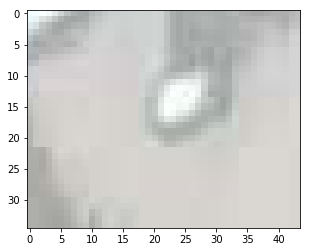

./data/annotation/grp_Beschädigung-5_num_35_id_124123372.xml
dellen


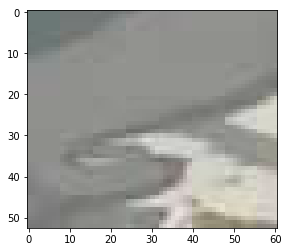

nothing


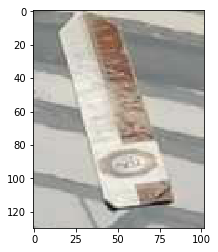

./data/annotation/grp_Beschädigung-10_num_56_id_153688840.xml
dellen


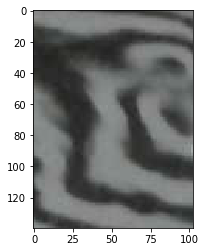

nothing


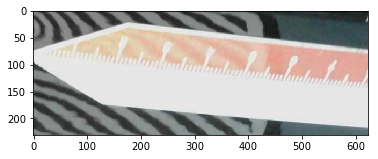

./data/annotation/grp_Beschädigung-2_num_25_id_145663341.xml
dellen


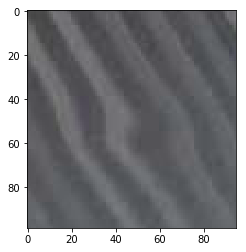

nothing


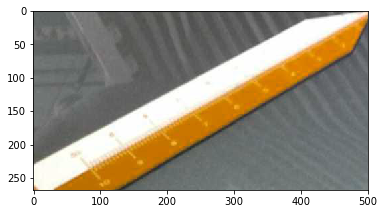

./data/annotation/grp_Beschädigung-1_num_26_id_135966260.xml
dellen


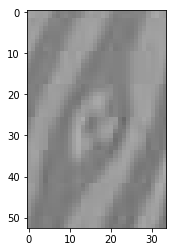

nothing


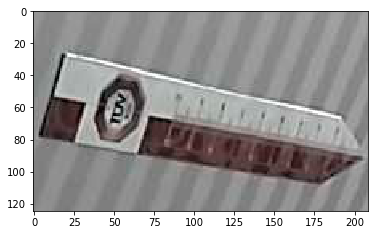

./data/annotation/grp_Beschädigung-2_num_31_id_155470997.xml
dellen


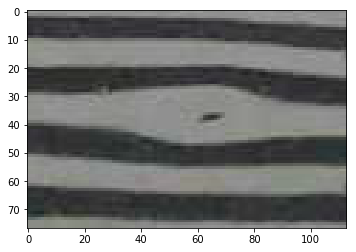

./data/annotation/grp_Beschädigung-6_num_39_id_166813680.xml
dellen


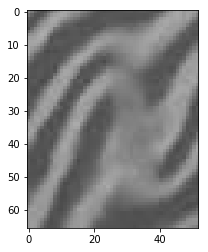

nothing


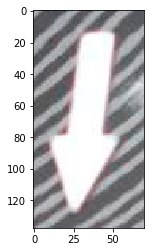

nothing


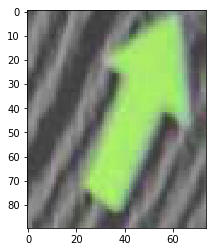

nothing


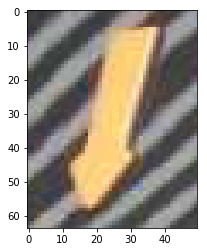

nothing


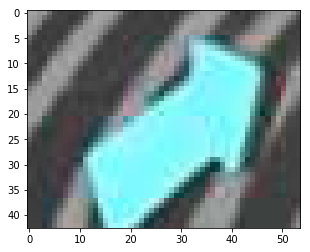

nothing


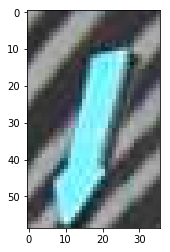

nothing


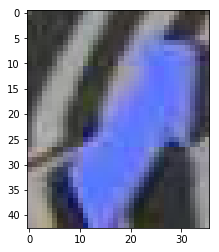

dellen


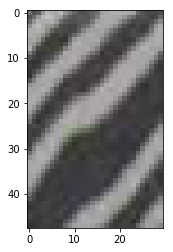

./data/annotation/grp_Beschädigung-2_num_18_id_154213026.xml
dellen


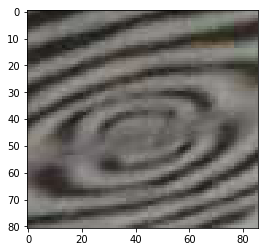

nothing


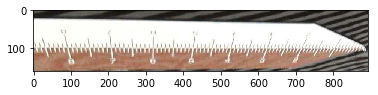

./data/annotation/grp_Beschädigung-5_num_25_id_154213031.xml
dellen


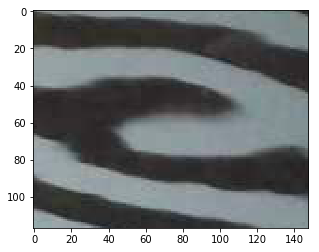

nothing


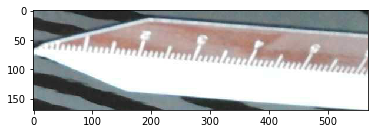

./data/annotation/grp_Beschädigung-8_num_43_id_126844248.xml
dellen


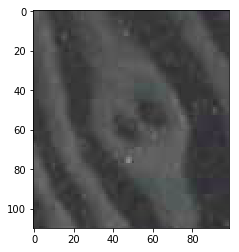

nothing


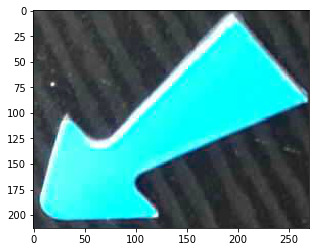

nothing


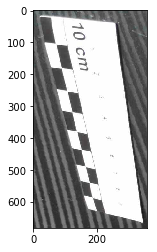

./data/annotation/grp_Beschädigung-4_num_26_id_155270246.xml
dellen


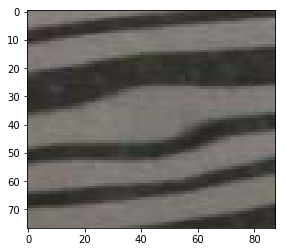

nothing


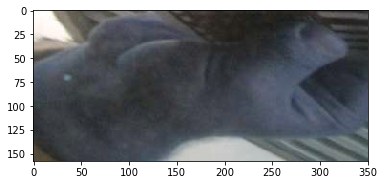

./data/annotation/grp_Beschädigung-5_num_33_id_176813644.xml
dellen


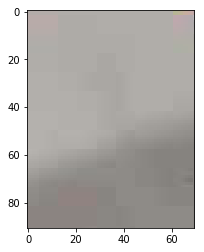

nothing


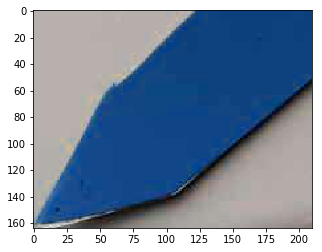

./data/annotation/grp_Beschädigung-1_num_36_id_142844763.xml
dellen


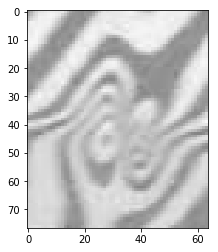

nothing


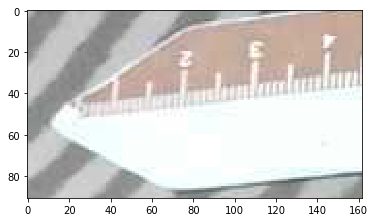

dellen


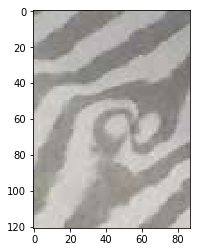

nothing


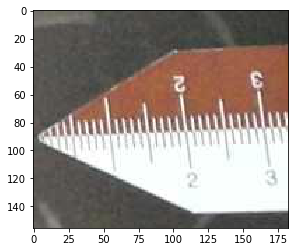

nothing


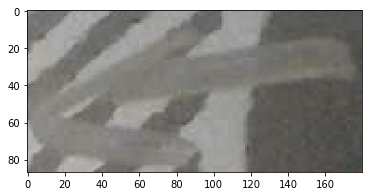

nothing


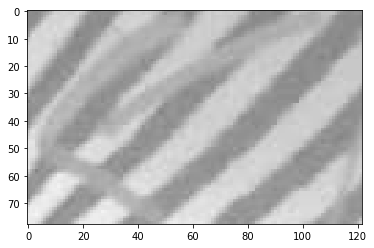

./data/annotation/grp_Beschädigung-6_num_45_id_157998239.xml
dellen


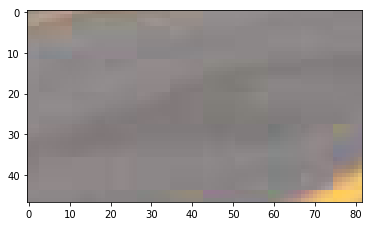

dellen


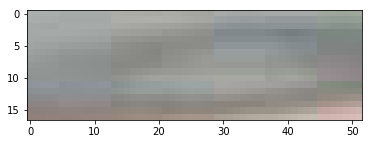

./data/annotation/grp_Beschädigung-1_num_26_id_131345385.xml
dellen


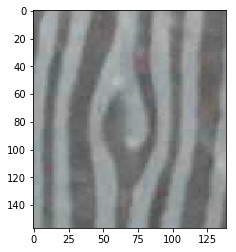

./data/annotation/grp_Beschädigung-3_num_17_id_136257880.xml
dellen


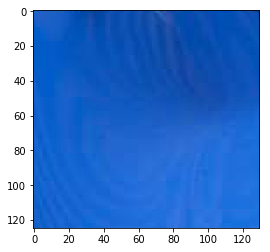

nothing


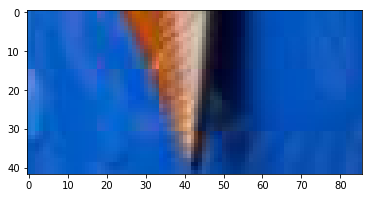

./data/annotation/grp_Beschädigung-3_num_27_id_133916046.xml
dellen


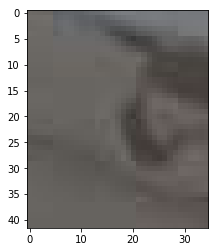

nothing


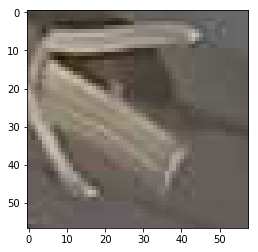

./data/annotation/grp_Beschädigung-4_num_20_id_135280182.xml
dellen


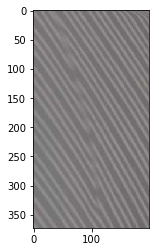

nothing


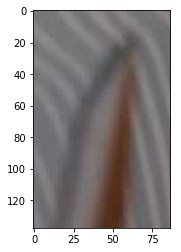

./data/annotation/grp_Beschädigung-3_num_15_id_130527692.xml
dellen


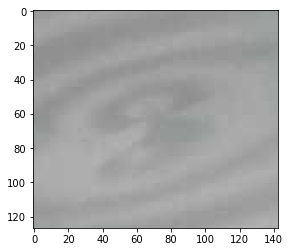

nothing


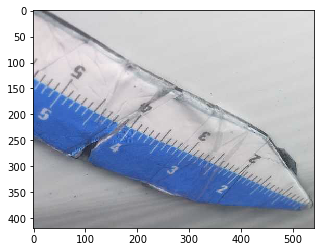

./data/annotation/grp_Beschädigung-5_num_30_id_164791876.xml
dellen


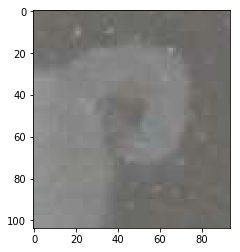

./data/annotation/grp_Beschädigung-2_num_28_id_129640999.xml
dellen


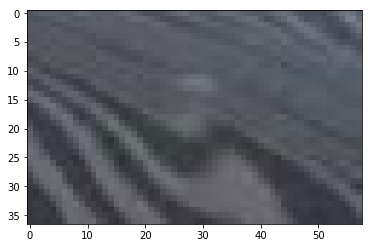

nothing


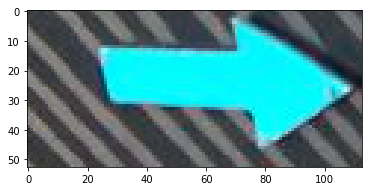

nothing


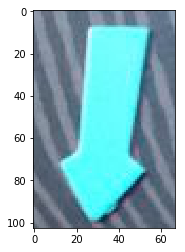

nothing


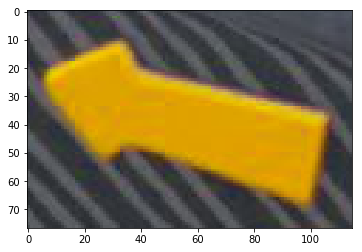

nothing


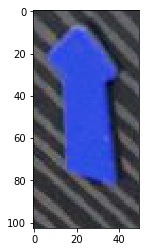

./data/annotation/grp_Beschädigung-1_num_38_id_141337704.xml
dellen


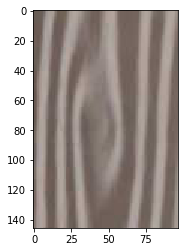

nothing


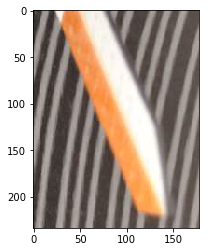

./data/annotation/grp_Beschädigung-9_num_35_id_167873480.xml
dellen


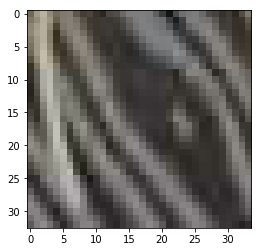

dellen


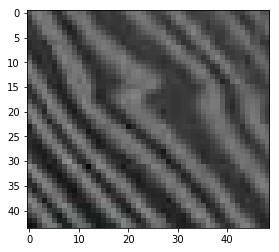

nothing


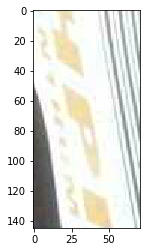

nothing


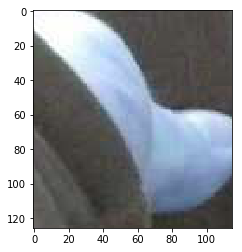

dellen


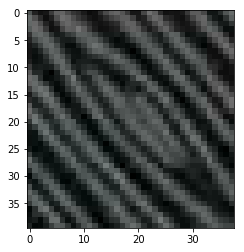

./data/annotation/grp_Beschädigung-4_num_26_id_153762739.xml
dellen


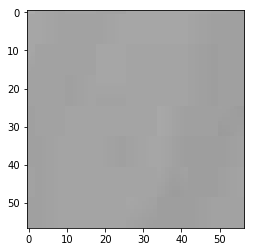

nothing


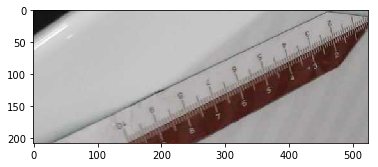

./data/annotation/grp_Beschädigung-5_num_42_id_157703372.xml
dellen


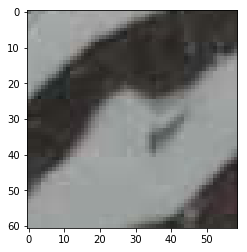

./data/annotation/grp_Beschädigung-7_num_43_id_135122219.xml
dellen


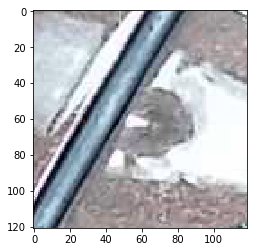

nothing


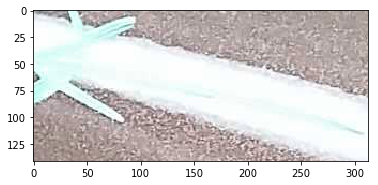

./data/annotation/grp_Beschädigung-9_num_33_id_160269761.xml
dellen


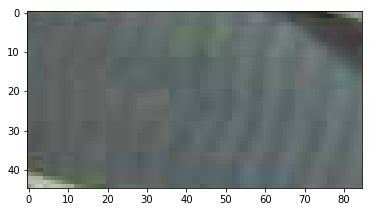

nothing


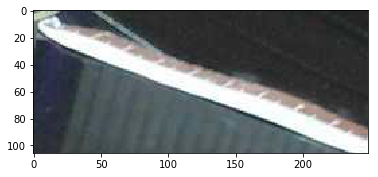

./data/annotation/grp_Beschädigung-5_num_35_id_134450747.xml
dellen


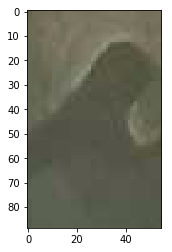

nothing


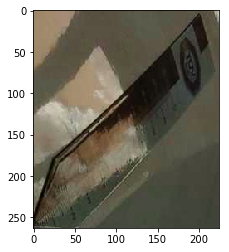

./data/annotation/grp_Beschädigung-2_num_26_id_157810407.xml
dellen


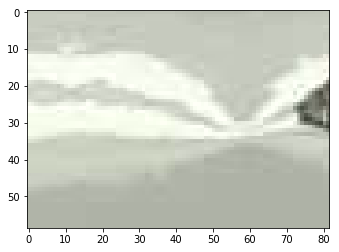

nothing


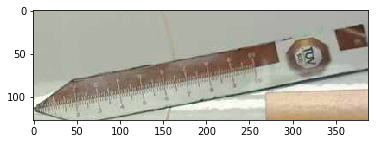

./data/annotation/grp_Beschädigung-1_num_29_id_134388045.xml
dellen


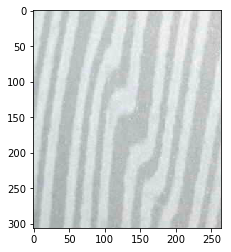

./data/annotation/grp_Beschädigung-5_num_23_id_152442722.xml
dellen


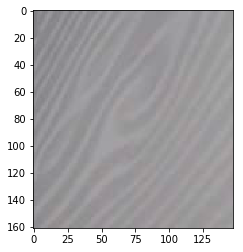

nothing


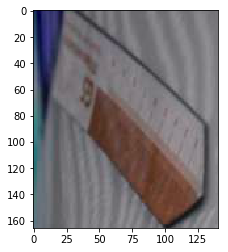

./data/annotation/grp_Beschädigung-4_num_18_id_121775466.xml
dellen


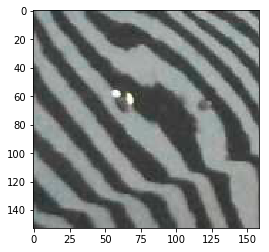

dellen


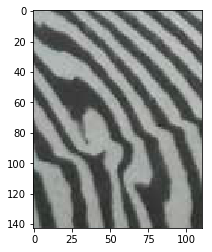

dellen


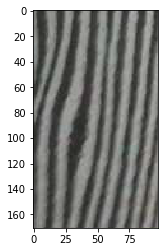

./data/annotation/grp_Beschädigung-1_num_27_id_152528203.xml
dellen


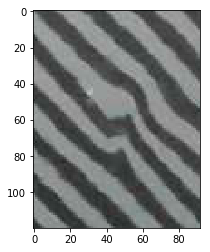

nothing


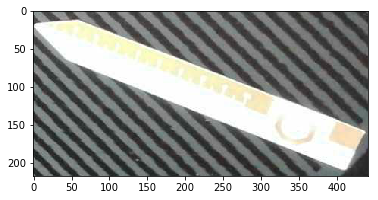

./data/annotation/grp_Beschädigung-1_num_35_id_145613208.xml
dellen


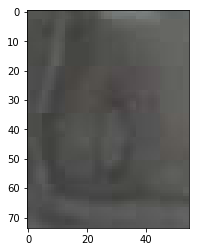

nothing


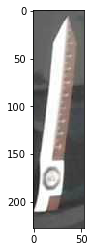

./data/annotation/grp_Beschädigung-3_num_35_id_165042543.xml
dellen


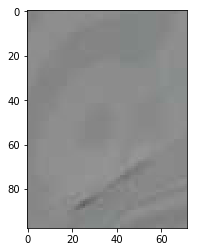

nothing


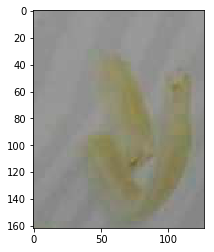

nothing


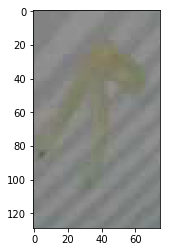

./data/annotation/grp_Beschädigung-3_num_30_id_164914272.xml
dellen


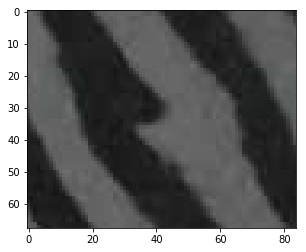

dellen


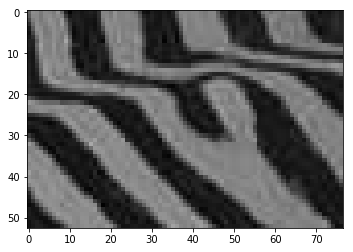

nothing


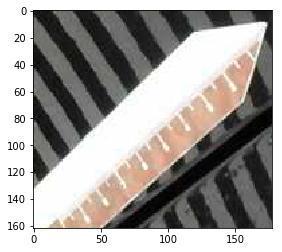

./data/annotation/grp_Beschädigung-4_num_23_id_122931572.xml
dellen


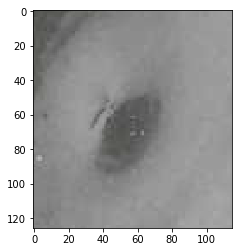

./data/annotation/grp_Beschädigung-25_num_69_id_163239175.xml
dellen


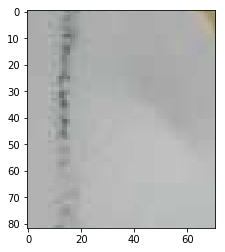

dellen


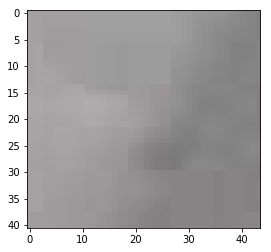

./data/annotation/grp_Beschädigung-2_num_19_id_152928983.xml
dellen


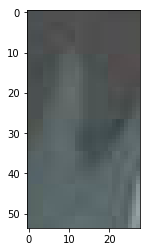

nothing


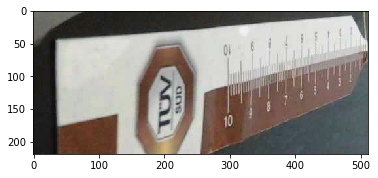

./data/annotation/grp_Beschädigung-4_num_33_id_145309431.xml
dellen


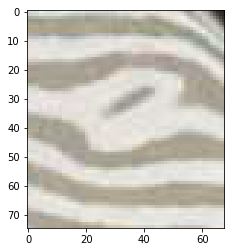

nothing


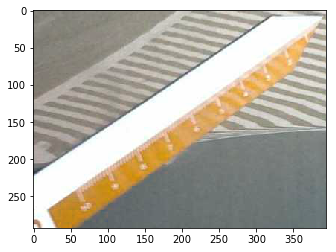

./data/annotation/grp_Beschädigung-3_num_35_id_139407252.xml
dellen


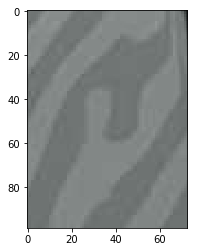

./data/annotation/grp_Beschädigung-1_num_33_id_146688546.xml
dellen


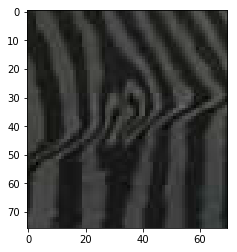

nothing


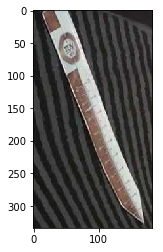

./data/annotation/grp_Beschädigung-2_num_28_id_128694583.xml
dellen


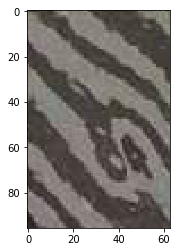

./data/annotation/grp_Beschädigung-2_num_21_id_153075574.xml
dellen


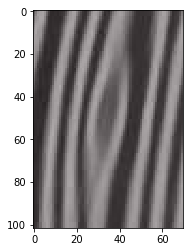

./data/annotation/grp_Beschädigung-3_num_27_id_166025547.xml
dellen


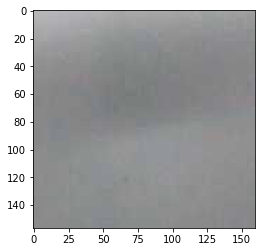

nothing


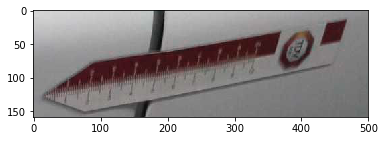

./data/annotation/grp_Beschädigung-4_num_37_id_168940216.xml
dellen


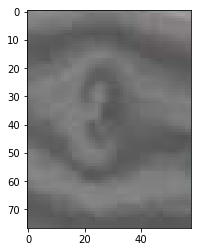

./data/annotation/grp_Beschädigung-3_num_26_id_155408348.xml
dellen


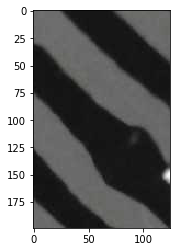

nothing


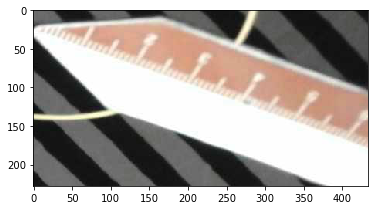

./data/annotation/grp_Beschädigung-6_num_42_id_146715614.xml
dellen


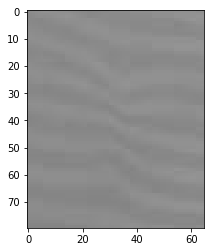

nothing


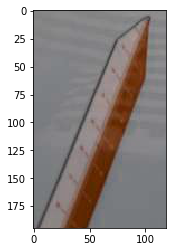

./data/annotation/grp_Beschädigung-1_num_27_id_128573865.xml
dellen


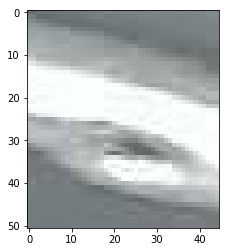

nothing


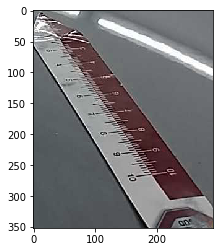

./data/annotation/grp_Beschädigung-3_num_34_id_132578289.xml
dellen


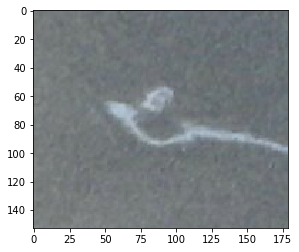

./data/annotation/grp_Beschädigung-5_num_32_id_145066755.xml
dellen


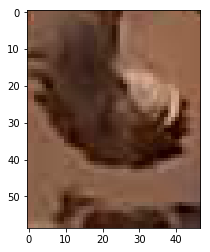

dellen


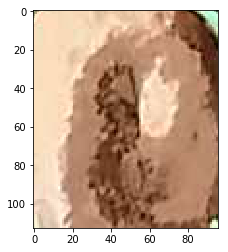

./data/annotation/grp_Beschädigung-2_num_33_id_140684435.xml
dellen


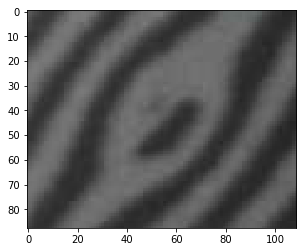

nothing


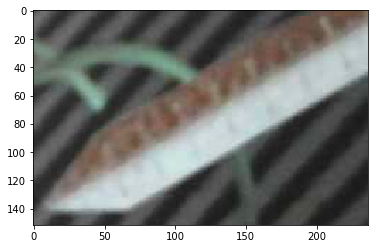

./data/annotation/grp_Beschädigung-2_num_33_id_143253977.xml
dellen


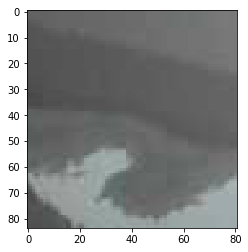

nothing


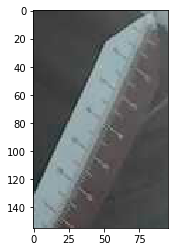

./data/annotation/grp_Beschädigung-5_num_36_id_126791382.xml
dellen


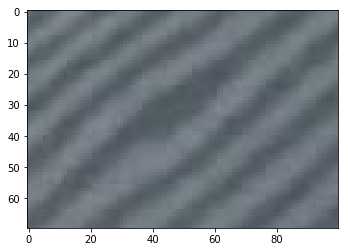

nothing


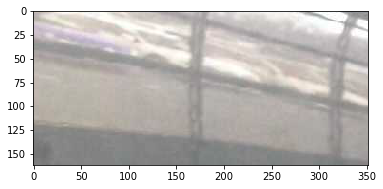

./data/annotation/grp_Beschädigung-1_num_36_id_132702363.xml
dellen


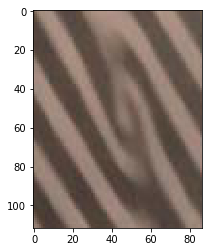

./data/annotation/grp_Beschädigung-3_num_33_id_132802590.xml
dellen


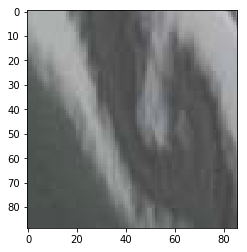

./data/annotation/grp_Beschädigung-4_num_37_id_148698580.xml
dellen


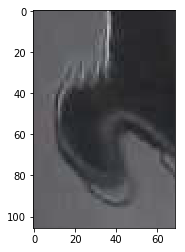

nothing


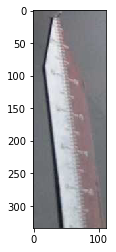

./data/annotation/grp_Beschädigung-3_num_24_id_163966585.xml
dellen


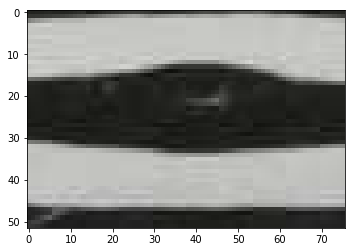

./data/annotation/grp_Beschädigung-3_num_13_id_127935199.xml
dellen


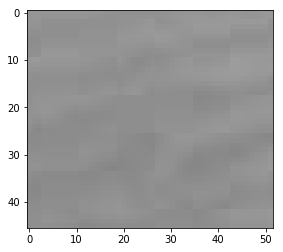

nothing


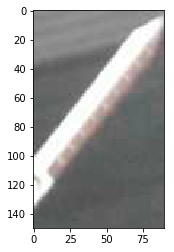

./data/annotation/grp_Beschädigung-5_num_18_id_127935167.xml
dellen


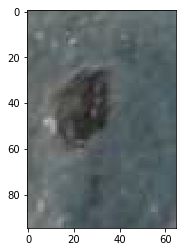

dellen


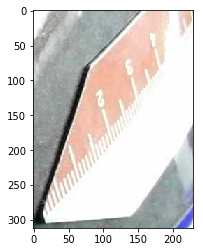

./data/annotation/grp_Beschädigung-3_num_24_id_142198488.xml
dellen


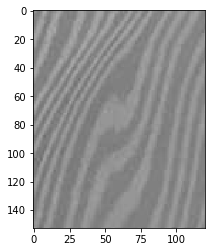

./data/annotation/grp_Beschädigung-2_num_28_id_157539879.xml
dellen


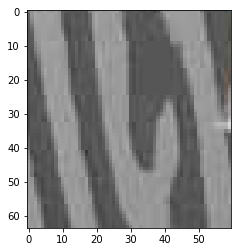

nothing


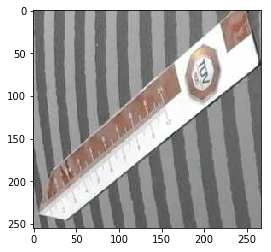

./data/annotation/grp_Beschädigung-3_num_33_id_139403941.xml
dellen


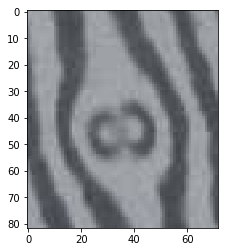

nothing


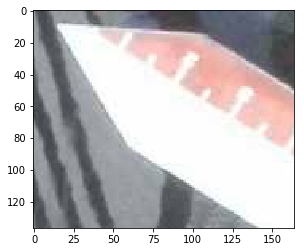

dellen


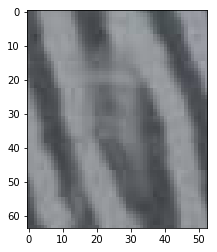

nothing


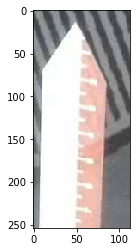

dellen


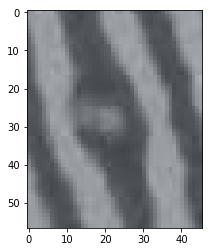

./data/annotation/grp_Beschädigung-15_num_52_id_155144097.xml
dellen


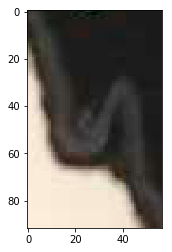

nothing


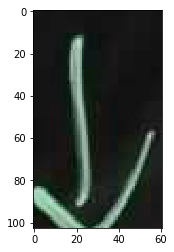

./data/annotation/grp_Beschädigung-6_num_31_id_150982225.xml
dellen


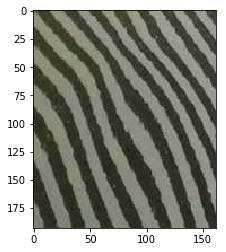

nothing


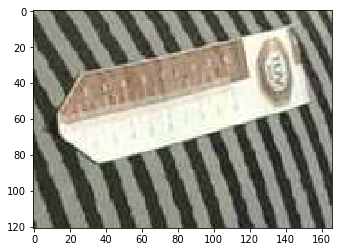

./data/annotation/grp_Beschädigung-2_num_30_id_129123512.xml
dellen


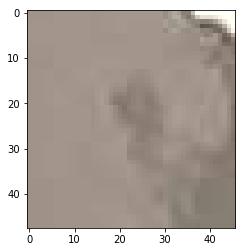

nothing


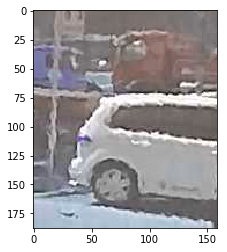

./data/annotation/grp_Beschädigung-4_num_25_id_137225926.xml
dellen


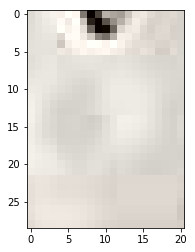

nothing


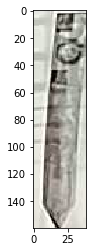

In [ ]:
df_batch['Done'] = df_batch.apply(lambda row: process_ann(row), axis=1)

In [108]:
df_crop = pd.DataFrame(crop_table, columns=crop_table_header)